# 📍 Recipe: Cumulative xG by Time per Team

In this example, we'll load event data for a match from StatsBomb's open dataset, extract shots and their xG values, and calculate the cumulative expected goals (xG) for each team over time.

We'll then plot the result using a stepped line chart in matplotlib to show the ebb and flow of attacking threat.

## 🧰 What You'll Learn

- How to access StatsBomb data using `Flow.statsbomb` methods
- How to filter for shot events and extract time and xG values
- Use `.group_by(...).cumulative(...)` to compute cumulative stats
- How to add a zero point to each team's cumulative xG so the chart starts at (0,0) using `.pipe()`
- How to convert to pandas and visualize using matplotlib

## Imports

In [1]:
from penaltyblog.matchflow import Flow, get_field, where_equals
import matplotlib.pyplot as plt

## Filter Shot Events

In [2]:
match_id = 22912  # Champions League Final 2018/2019

shots = (
    Flow.statsbomb.events(match_id)
    .filter(where_equals("type.name", "Shot"))
    .assign(
        team=lambda r: get_field(r, "team.name"),
        xg=lambda r: get_field(r, "shot.statsbomb_xg") or 0,
        time=lambda r: r.get("minute", 0) * 60 + r.get("second", 0),
    )
    .select("time", "team", "xg")
    .sort_by("time")
)

## Group by Team and Compute Cumulative xG

Note how we use the `.pipe()` method to add the zero point to each team's cumulative xG so the chart starts at (0,0)

In [ ]:
def add_zero_point(flow: Flow) -> Flow:
    teams = flow.select("team").distinct().collect()
    zeros = [{"team": t["team"], "time": 0, "cumulative_xg": 0.0} for t in teams]
    return Flow.from_records(zeros).concat(flow)


cum_xg = (
    shots.group_by("team")
    .cumulative(field="xg", alias="cumulative_xg")
    .pipe(add_zero_point)
    .sort_by("time")
)

## Plot Chart

/Users/martin/repos/penaltyblog/venv/lib/python3.13/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


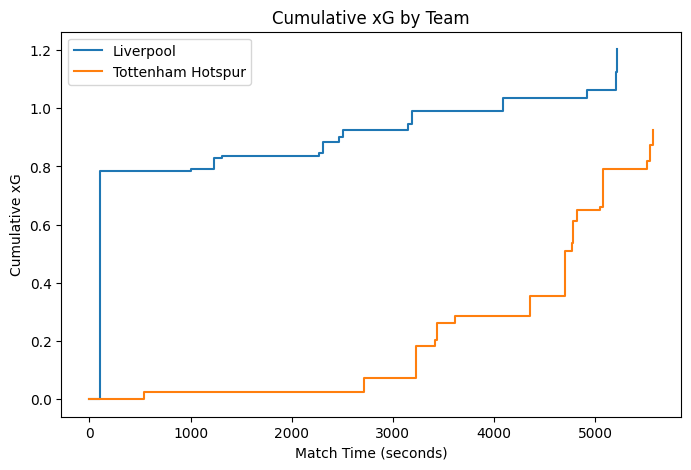

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))

for team, records in cum_xg.grouped("team"):
    times = [r["time"] for r in records]
    xgs = [r["cumulative_xg"] for r in records]
    ax.step(times, xgs, where="post", label=team)

ax.set_xlabel("Match Time (seconds)")
ax.set_ylabel("Cumulative xG")
ax.set_title("Cumulative xG by Team")
ax.legend()